In [98]:
import json
import os
from dataclasses import dataclass
import matplotlib.pyplot as plt
import tables
from dataforge import Meta, Name
from phd.thunderstorm.dwyer_feedback import get_bins_from_center, load_reversed_data, histogrammed_reverse_data, \
    histogrammed_reverse_data_v2, ReverseHistogramm
from phd.utils.convertor_tools import direction_to_degree
from scipy.interpolate import UnivariateSpline
import numpy as np
import matplotlib as mpl
import tables
from phd.utils.path_tools import find_by_meta, get_attrs_values
from scipy.optimize import curve_fit
from tables import File, Group

In [2]:
path1 = "/mnt/storage2/phd/data/thunderstorm/reversed_1/grid_1.hdf5"
path2 = "/mnt/storage2/phd/data/thunderstorm/reversed_1/grid_2.hdf5"
fields = get_attrs_values(path1, "values_gdml_fieldValueZ")
fields = sorted(list(fields))

In [21]:
def count_feedback(data, field):
    reverseHist = histogrammed_reverse_data(path1, path2, field)
    result = reverseHist.calculate_reverse_ET(data)
    return result

In [5]:
path = "/mnt/storage2/phd/data/thunderstorm/dwyer2003/test_dwayer2003.hdf5"
def get_data(path, target_node="gamma", cellHeight = 400, field=5.2e-4):
    paths = find_by_meta(path,target_node=target_node, values_gdml_cellHeight=cellHeight)
    with tables.open_file(path) as h5file:
        for i, path in enumerate(paths):
            table = h5file.get_node(path)
            data = table.read()
            print(repr(table.attrs))
            return data
    

In [6]:
data_gamma = get_data(path)

/sim0004/gamma._v_attrs (AttributeSet), 27 attributes:
   [CLASS := 'TABLE',
    FIELD_0_FILL := 0.0,
    FIELD_0_NAME := 'energy',
    FIELD_1_FILL := 0.0,
    FIELD_1_NAME := 'theta',
    FIELD_2_FILL := 0.0,
    FIELD_2_NAME := 'radius',
    FIELD_3_FILL := 0.0,
    FIELD_3_NAME := 'z',
    NROWS := 16970,
    TITLE := '',
    VERSION := '2.7',
    path := 'sim0004',
    text := '/df/project test\n/df/gdml .././gdml/3.gdml\n/thunderstorm/physics standard_opt_4\n/thunderstorm/stacking dwyer2003\n/thunderstorm/cut/energy 0.05\n\n/gps/particle e-\n/gps/number 1\n/gps/direction 0 0 -1\n/gps/ene/mono 1.0 MeV\n/gps/position 0. 0. 200 m\n/run/beamOn 10\n',
    values_gdml_cellHeight := 400,
    values_gdml_fieldValueZ := 0.00052,
    values_gdml_height := 0,
    values_macros_cut := 0.05,
    values_macros_direction := '0 0 -1',
    values_macros_energy := 1.0,
    values_macros_number := 10,
    values_macros_particle := 'e-',
    values_macros_path := '.././gdml/3.gdml',
    values_macro

In [36]:
data = data_gamma
field=5.5e-4
reverseHist = histogrammed_reverse_data(path1, path2, field)
result = reverseHist.calculate_reverse_ET(data)


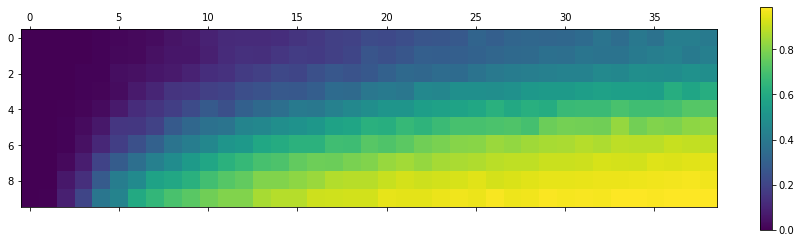

In [37]:
plt.matshow(reverseHist.probability)
plt.colorbar();

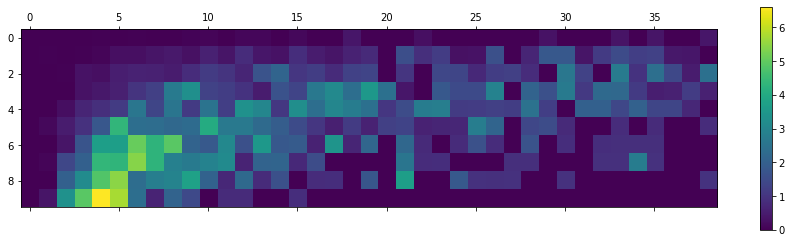

In [38]:
plt.matshow(result)
plt.colorbar();

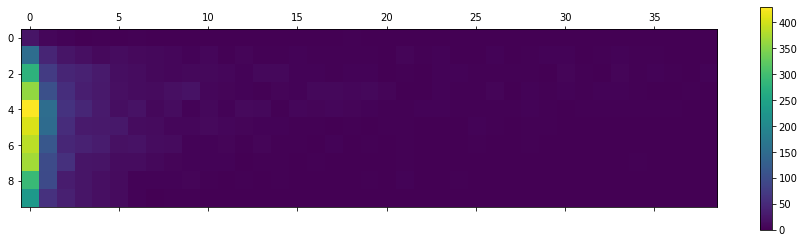

In [32]:
hist , _, _ = np.histogram2d(np.rad2deg(data_gamma["theta"]), data["energy"], bins=(reverseHist.theta_bins, reverseHist.energy_bins))
plt.matshow(hist)
plt.colorbar()

In [39]:
result.sum()

425.071

Разворот v2

In [12]:
path_reverse = "/mnt/storage2/phd/data/thunderstorm/reversed_1/grid_v2.hdf5"

In [13]:
data = data_gamma
field=5.5e-4
reverseHist = histogrammed_reverse_data_v2(path_reverse, field)
result = reverseHist.calculate_reverse_ET(data)


In [14]:
result.sum()



517.605

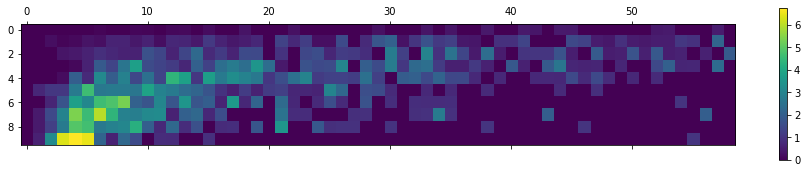

In [15]:
plt.matshow(result)
plt.colorbar();

In [89]:
@dataclass
class FeedBack:
    height: float
    field : float
    cell : float
    gamma: float
    positron: float
    gamma_err: float
    positron_err: float
    number_of_seed: float

In [ ]:
class FeedBackCalculator:
    
    def __init__(self, reverseHist : ReverseHistogramm):
        self.reverseHist = reverseHist
        
    def calculate(self, data):
        if data.size != 0:
            result = reverseHist.calculate_reverse_ET(data)
            return result.sum()
        else:
            return 0
        
    
    def calculate_from_node(self, h5file: File, group: Group):
        table_gamma = h5file.get_node(group, "gamma")
        number = table_gamma.attrs["values_macros_number"]
        height = table_gamma.attrs["values_gdml_height"]
        cell = table_gamma.attrs["values_gdml_cellHeight"]
        field = table_gamma.attrs["values_gdml_fieldValueZ"]
        
        table_positron = h5file.get_node(group,"positron")
        pos_fb = self.calculate(table_positron.read())
        gamma_fb = self.calculate(table_gamma.read())
        gamma_err = (gamma_fb**0.5)/number
        pos_err = (pos_fb**0.5)/number
        gamma_fb =  gamma_fb/number
        pos_fb = pos_fb/number
        return FeedBack(height, field, cell, gamma_fb, pos_fb, gamma_err, pos_err, number)
        

In [63]:
fbCalc = FeedBackCalculator(reverseHist)

In [52]:
def find_group_by_meta(filename, **kwargs):
    result = []
    with tables.open_file(filename) as h5file:
        for group in h5file.root:
            meta = h5file.get_node(group, "meta").read()
            meta = Meta(json.loads(meta))
            flag = True
            for key, value in kwargs.items():
                name = Name.from_string(key.replace("_", "."))
                if meta[name] != value:
                    flag = False
                    break
            if flag:
                result.append(group._v_pathname)
    return result

In [53]:
paths = find_group_by_meta(path, values_gdml_fieldValueZ=5.5e-4)

In [125]:
path = "/mnt/storage2/phd/data/thunderstorm/dwyer2003/diff_0.hdf5"
def calc_fb(path, fbCalc: FeedBackCalculator, field):
    result = []
    print("field", field)
    paths = find_group_by_meta(path, values_gdml_fieldValueZ=field)
    print(paths)
    with tables.open_file(path) as h5file:
        for p in paths:
            result.append(fbCalc.calculate_from_node(h5file, p))
    return result
    

In [67]:
fields = get_attrs_values(path_reverse, "values_gdml_fieldValueZ")
fields = sorted(list(fields))
print(fields)

[0.0005, 0.00055, 0.0006000000000000001, 0.0006500000000000001, 0.0007, 0.00075, 0.0008, 0.0008500000000000001, 0.0009000000000000001, 0.00095, 0.001]


In [88]:
result = []
path = "/mnt/storage2/phd/data/thunderstorm/dwyer2003/"
for field in fields:
    reverseHist = histogrammed_reverse_data_v2(path_reverse, field)
    fbCalc = FeedBackCalculator(reverseHist)
    for i in range(6):
        path_hdf5 = os.path.join(path, f"diff_{i}.hdf5")
        result += calc_fb(path_hdf5, fbCalc, field)

In [133]:
result_1 = []
path = "/mnt/storage2/phd/data/thunderstorm/dwyer2003/"
reverseHist = histogrammed_reverse_data_v2(path_reverse, 5e-4)
fbCalc = FeedBackCalculator(reverseHist)
for i in range(6):
    path_hdf5 = os.path.join(path, f"diff_{i}.hdf5")
    result_1 += calc_fb(path_hdf5, fbCalc, 4e-4)

field 0.0004
[]
field 0.0004
['/sim0007']
field 0.0004
[]
field 0.0004
[]
field 0.0004
[]
field 0.0004
[]


In [131]:
print(result_1[0].number_of_seed)

1


In [134]:
path = "/mnt/storage2/phd/data/thunderstorm/dwyer2003/"
for i in range(6):
    path_hdf5 = os.path.join(path, f"diff_{i}.hdf5")
    result_1 += calc_fb(path_hdf5, fbCalc, 4.5e-4)

field 0.00045
[]
field 0.00045
['/sim0006']
field 0.00045
[]
field 0.00045
[]
field 0.00045
[]
field 0.00045
[]


In [138]:
print(result_1[1])
path = "/mnt/storage2/phd/data/thunderstorm/dwyer2003/"
reverseHist = histogrammed_reverse_data_v2(path_reverse, fields[2])
fbCalc = FeedBackCalculator(reverseHist)
for i in range(6):
    path_hdf5 = os.path.join(path, f"diff_{i}.hdf5")
    result_1 += calc_fb(path_hdf5, fbCalc, 6e-4)

FeedBack(height=0, field=0.00045, cell=700, gamma=110.725, positron=335.69500000000005, gamma_err=10.52259473704086, positron_err=18.321981333906006, number_of_seed=1)
field 0.0006
[]
field 0.0006
['/sim0003']
field 0.0006
['/sim0003']
field 0.0006
[]
field 0.0006
['/sim0003', '/sim0006', '/sim0009', '/sim0012']
field 0.0006
['/sim0003']


In [121]:
path = "/mnt/storage2/phd/data/thunderstorm/dwyer2003/"
for i in range(6):
    path_hdf5 = os.path.join(path, f"diff_{i}.hdf5")
    with tables.open_file(path_hdf5) as h5file:
        print(len(h5file.list_nodes("/")))

1
7
3
8
12
3


In [122]:
print(len(result))

25


In [83]:
from tabulate import tabulate
import pickle

In [84]:
with open("feed_back.obj", "wb") as fout:
    pickle.dump(result, fout)    

In [93]:
summary_result = []
for field in fields:
    temp = []
    for item in result:
        if item.field == field:
            temp.append(item)
    if temp != []:
        gamma_tot = sum([it.number_of_seed*it.gamma for it in temp])/sum([it.number_of_seed for it in temp])
        pos_tot = sum([it.number_of_seed*it.positron for it in temp])/sum([it.number_of_seed for it in temp])
        gamma_err = (sum([it.number_of_seed*it.gamma for it in temp])**0.5)/sum([it.number_of_seed for it in temp])
        pos_err = (sum([it.number_of_seed*it.positron for it in temp])**0.5)/sum([it.number_of_seed for it in temp])
        summary_result.append(
            FeedBack(
                temp[0].height,
                field,
                temp[0].cell,
                gamma_tot,
                pos_tot,
                gamma_err,
                pos_err,
                sum([it.number_of_seed for it in temp])
            )
        )

In [142]:
summary_result.append(result_1[0])
summary_result.append(result_1[1])

In [149]:
summary_result_6 = []

temp =  result_1[2:]
gamma_tot = sum([it.number_of_seed*it.gamma for it in temp])/sum([it.number_of_seed for it in temp])
pos_tot = sum([it.number_of_seed*it.positron for it in temp])/sum([it.number_of_seed for it in temp])
gamma_err = (sum([it.number_of_seed*it.gamma for it in temp])**0.5)/sum([it.number_of_seed for it in temp])
pos_err = (sum([it.number_of_seed*it.positron for it in temp])**0.5)/sum([it.number_of_seed for it in temp])
summary_result_6.append(
    FeedBack(
        temp[0].height,
        6e-4,
        temp[0].cell,
        gamma_tot,
        pos_tot,
        gamma_err,
        pos_err,
        sum([it.number_of_seed for it in temp])
    )
)

In [150]:
summary_result.append(summary_result_6[0])

In [151]:
for it in summary_result:
    print(it)
    

FeedBack(height=0, field=0.0005, cell=500, gamma=51.04, positron=137.86999999999998, gamma_err=7.1442284397967, positron_err=11.741805653305626, number_of_seed=1)
FeedBack(height=0, field=0.00055, cell=400, gamma=32.87387096774194, positron=15.192580645161291, gamma_err=1.0297802923790689, positron_err=0.7000594593447803, number_of_seed=31)
FeedBack(height=0, field=0.0007, cell=200, gamma=7.083146551724139, positron=8.131831896551724, gamma_err=0.17473066159738312, positron_err=0.1872191217640502, number_of_seed=232)
FeedBack(height=0, field=0.001, cell=100, gamma=4.946293103448276, positron=1.6895258620689657, gamma_err=0.14601448179606571, positron_err=0.08533720794965167, number_of_seed=232)
FeedBack(height=0, field=0.0004, cell=1000, gamma=0.0, positron=0.0, gamma_err=0.0, positron_err=0.0, number_of_seed=1)
FeedBack(height=0, field=0.00045, cell=700, gamma=110.725, positron=335.69500000000005, gamma_err=10.52259473704086, positron_err=18.321981333906006, number_of_seed=1)
FeedBack

In [113]:
with open("sum_feed_back.obj", "wb") as fout:
    pickle.dump(summary_result, fout)  

In [95]:
def get_dwyer_line():
    path = "/mnt/storage2/phd/data/thunderstorm/Graph/Dwyer2003.dat"
    with open(path) as fin:
        text = fin.read()
        text = text.replace(",", ".")
        text = text.split("\n")
        data = [[float(i) for i in line.split()] for line in text[:-1]]
    data = np.array(data)

    def power(x, alpha, const, back):
        return const * np.exp(-x / alpha) + back

    popt, _ = curve_fit(power, xdata=np.log(data[:, 0]), ydata=np.log(data[:, 1]), p0=[100, 2000, 500])
    return lambda x :  np.exp(power(np.log(x), *popt))

In [99]:
dwyer_line = get_dwyer_line()

In [109]:
import warnings

warnings.simplefilter("ignore")
mpl.rcParams.update(
    {'font.family': 'sans-serif',
     'font.size': 16,
     'axes.labelsize': 16,
     'xtick.labelsize': 16,
     'ytick.labelsize': 16,
     'legend.fontsize': 16})

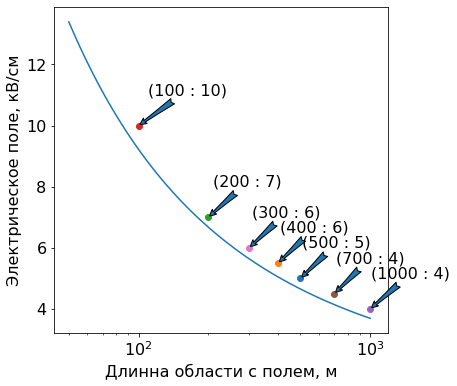

In [174]:
x = np.arange(50, 1001, 1)
plt.figure(figsize=(6,6))
plt.plot(x, dwyer_line(x)/100)
plt.xscale("log")
plt.ylabel("Электрическое поле, кВ/см")
plt.xlabel("Длинна области с полем, м")
for item in summary_result:
    plt.scatter(item.cell, item.field*1e4)
    text = "({:.0f} : {:.0f})".format(item.cell, item.field*1e4)
    plt.annotate(text, (item.cell, item.field*1e4),
                 xytext = (item.cell+10, item.field*1e4 + 1),
                 arrowprops = {"arrowstyle" : "fancy"})
plt.savefig("dwyer.png",  dpi=600)

In [163]:
sorted_res = sorted(summary_result, key = lambda x: x.field)
for item in sorted_res:
    print(item.field, item.cell, round(item.gamma), round(100*item.gamma_err/item.gamma) , round(item.positron), round(100*item.positron_err/item.positron) )

0.0004 1000 0.0 nan 0.0 nan
0.00045 700 111.0 10.0 336.0 5.0
0.0005 500 51.0 14.0 138.0 9.0
0.00055 400 33.0 3.0 15.0 5.0
0.0006 300 30.0 3.0 58.0 2.0
0.0007 200 7.0 2.0 8.0 2.0
0.001 100 5.0 3.0 2.0 5.0


/home/zelenyy/miniconda3/envs/phd-code/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [167]:

path = "/mnt/storage2/phd/data/thunderstorm/dwyer2003/"
over_3mev = []
for i in range(6):
    path_hdf5 = os.path.join(path, f"diff_{i}.hdf5")
    with tables.open_file(path_hdf5) as h5file:
        for group in h5file.root:
            for name in ["gamma", "positron"]:
                table = h5file.get_node(group, name)
                number = table.attrs["values_macros_number"]
                height = table.attrs["values_gdml_height"]
                cell = table.attrs["values_gdml_cellHeight"]
                field = table.attrs["values_gdml_fieldValueZ"] 
                data = table.read()
                indx = data["energy"] > 3
                over_3mev.append([name, field, cell, indx.sum(), number, indx.sum()/number])

In [169]:
for item in over_3mev:
    if item[0] != "gamma": continue
    if item[1] == 0.001 or item[1]==0.0007: continue
    print(item[1], item[-1])


0.00055 1500.1333333333334
0.0006 45.0
0.00055 106.0
0.0005 48.0
0.00045 96.0
0.0004 0.0
0.0006 10.6
0.0006 13.2
0.0006 8.0
0.0006 4.0
0.0006 11.0
0.0006 11.0


In [170]:
for item in over_3mev:
    if item[0] != "positron": continue
    if item[1] == 0.001 or item[1]==0.0007: continue
    print(item[1], item[-1])



0.00055 72.46666666666667
0.0006 30.0
0.00055 67.0
0.0005 25.0
0.00045 72.0
0.0004 0.0
0.0006 10.3
0.0006 12.0
0.0006 8.2
0.0006 2.0
0.0006 8.2
0.0006 5.0
